## Yelp Photo Classification with CNN from Scratch. 

Note that the train, test and the valid dataset contains 5 classes: food, menu, outside, interior and drink. Here the train folder has 6000 images, the validation and test folder has 1000 images respectively.

In [1]:
# General Libs
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Create a path to the train, test & valid folder

In [2]:
train_path = '/content/drive/MyDrive/Datasets/train_dir'
test_path = '/content/drive/MyDrive/Datasets/test_dir'
valid_path = '/content/drive/MyDrive/Datasets/valid_dir'

In [3]:
train_folder = Path(train_path)
test_folder = Path(test_path)
valid_folder=Path(valid_path)

In [4]:
train_folder = Path('/content/drive/MyDrive/Datasets/train_dir')
test_folder = Path(f'/content/drive/MyDrive/Datasets/test_dir')
valid_folder = Path('/content/drive/MyDrive/Datasets/valid_dir')

In [5]:
train_size = 6000
valid_size = 1000
test_size = 1000
img_height = 224
img_width = 224
n_classes = 5
batch_size = 32
n_epochs = 50

### Create CNN model from Scratch for Classification

In [6]:
# Standardize the data
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create batches of data from each set train, test and validation)
train_ds = datagen.flow_from_directory(directory=train_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

valid_ds = datagen.flow_from_directory(directory=valid_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

test_ds = datagen.flow_from_directory(directory=test_folder,
                                              target_size=(img_height,
                                                           img_width),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False)

Found 6000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


Plot the label dictionary for the train dataset

In [7]:
print('Number of samples: ',test_ds.samples)
print('Number of classes: ',len(test_ds.class_indices))
print('Number of samples per class:', int(test_ds.samples/len(test_ds.class_indices)))

Number of samples:  1000
Number of classes:  5
Number of samples per class: 200


In [8]:
labels = {value: key for key, value in test_ds.class_indices.items()}

print("Label Mappings for classes present in the training dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training dataset

0 : drink
1 : food
2 : interior
3 : menu
4 : outside


In [9]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


Let us see what are the images in the train generator

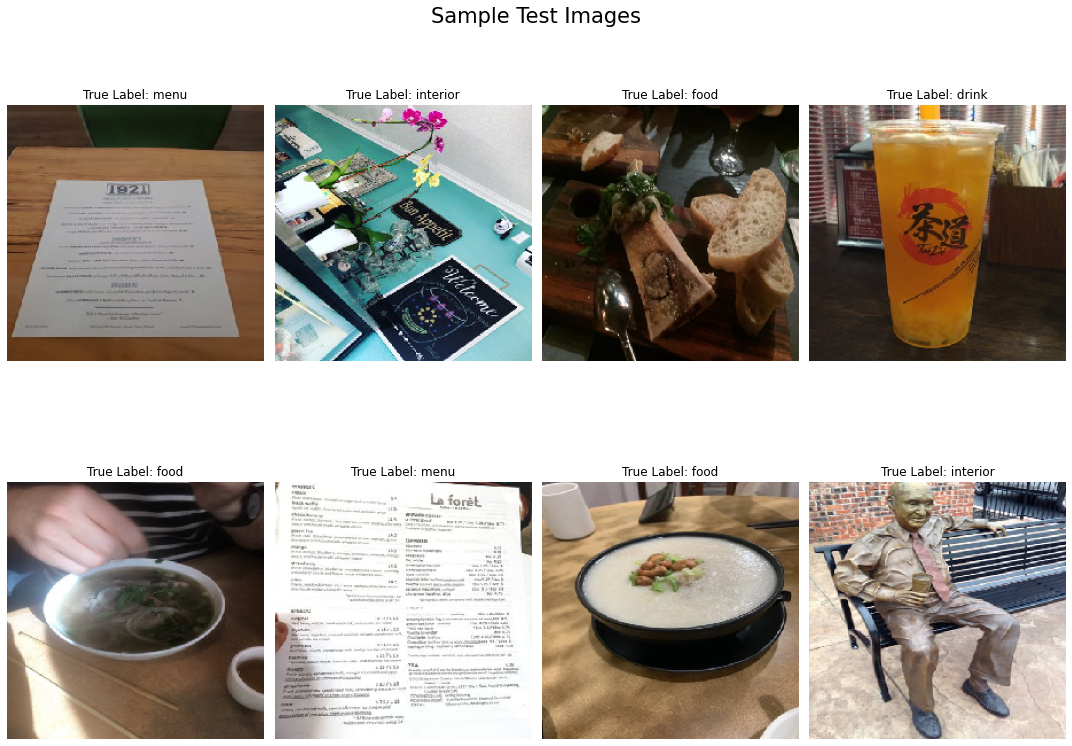

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_ds[0][1][idx])]
        ax[i, j].set_title(f"True Label: {label}")
        ax[i, j].imshow(train_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Test Images", fontsize=21)
plt.show()

### Create a CNN classification model from scratch

In [11]:
def create_model():
    model = Sequential([
        Conv2D(128, kernel_size=(5, 5), padding='same', input_shape=(img_width, img_height, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    
    return model

In [12]:
full_model = create_model()

In [13]:
full_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 activation (Activation)     (None, 224, 224, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 112, 112, 64)      0

In [14]:
# Utilize the Adam Optimizers
opt = keras.optimizers.Adam(learning_rate=1e-5)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

In [15]:
# Use Early Stopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

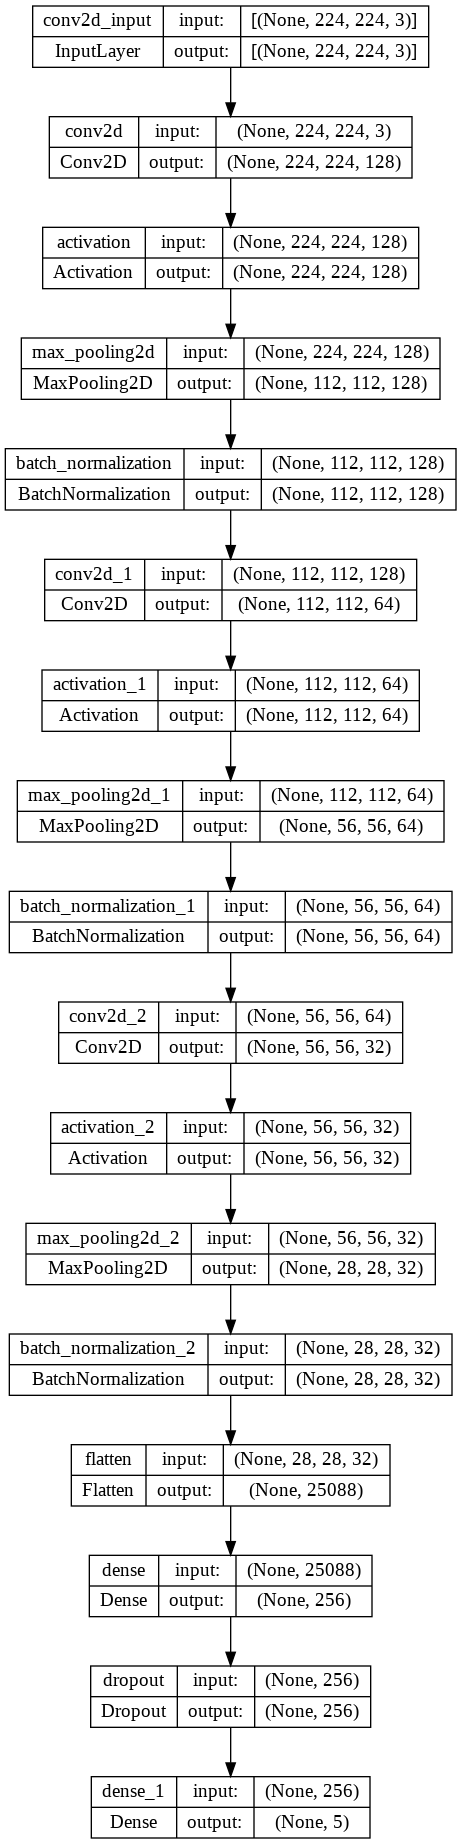

In [16]:
# Plot the model
dot_img_file = 'model_cnn.png'
tf.keras.utils.plot_model(full_model, to_file=dot_img_file, show_shapes=True)

In [17]:
history = full_model.fit(train_ds,epochs=n_epochs,
                               validation_data=valid_ds,
                               steps_per_epoch=train_size / batch_size,
                               validation_steps=valid_size / batch_size, 
                               callbacks=[es])

Epoch 1/50
187/187 [==============================] - 2796s 15s/step - loss: 1.7380 - accuracy: 0.4518 - val_loss: 2.0697 - val_accuracy: 0.1990
Epoch 2/50
187/187 [==============================] - 44s 236ms/step - loss: 1.2249 - accuracy: 0.5792 - val_loss: 1.7289 - val_accuracy: 0.3020
Epoch 3/50
187/187 [==============================] - 44s 235ms/step - loss: 0.9739 - accuracy: 0.6463 - val_loss: 1.1135 - val_accuracy: 0.5910
Epoch 4/50
187/187 [==============================] - 44s 236ms/step - loss: 0.8256 - accuracy: 0.6932 - val_loss: 0.9701 - val_accuracy: 0.6520
Epoch 5/50
187/187 [==============================] - 44s 234ms/step - loss: 0.7127 - accuracy: 0.7378 - val_loss: 0.9438 - val_accuracy: 0.6530
Epoch 6/50
187/187 [==============================] - 46s 243ms/step - loss: 0.6009 - accuracy: 0.7718 - val_loss: 0.9265 - val_accuracy: 0.6700
Epoch 7/50
187/187 [==============================] - 44s 235ms/step - loss: 0.5289 - accuracy: 0.8095 - val_loss: 0.9139 - val_ac

### Save the model as a h5 file

In [18]:
full_model.save('/content/drive/MyDrive/Datasets/Models/CNNSCRATCH.h5')

### Plot the learning curves

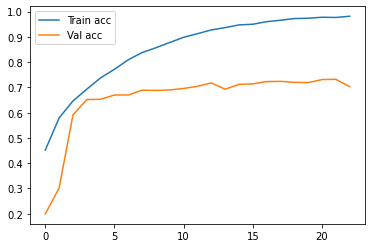

In [19]:
# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.show()

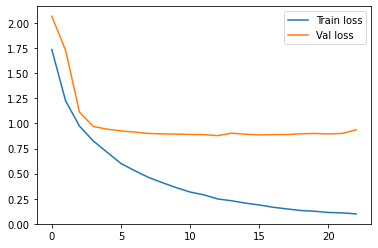

In [20]:
# loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

### Predict the model performance on the test dataset

In [21]:
test_loss, test_accuracy = full_model.evaluate(test_ds)

32/32 [==============================] - 331s 11s/step - loss: 0.9316 - accuracy: 0.6990


In [22]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.9315840601921082
Test Accuracy: 0.6990000009536743


In [23]:
model = load_model('/content/drive/MyDrive/Datasets/Models/CNNSCRATCH.h5')

In [24]:
preds = model.predict(test_ds, batch_size=batch_size)

y_pred=np.argmax(preds,axis=1)
y_true = test_ds.classes

32/32 [==============================] - 6s 176ms/step


### Plot the Classification matrix

In [25]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

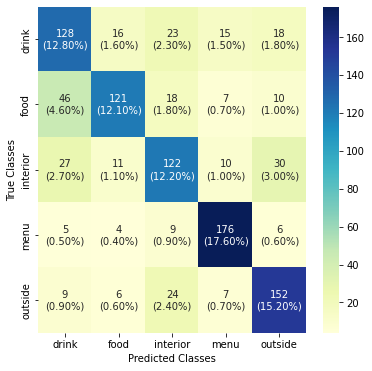

In [26]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (6, 6))
sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

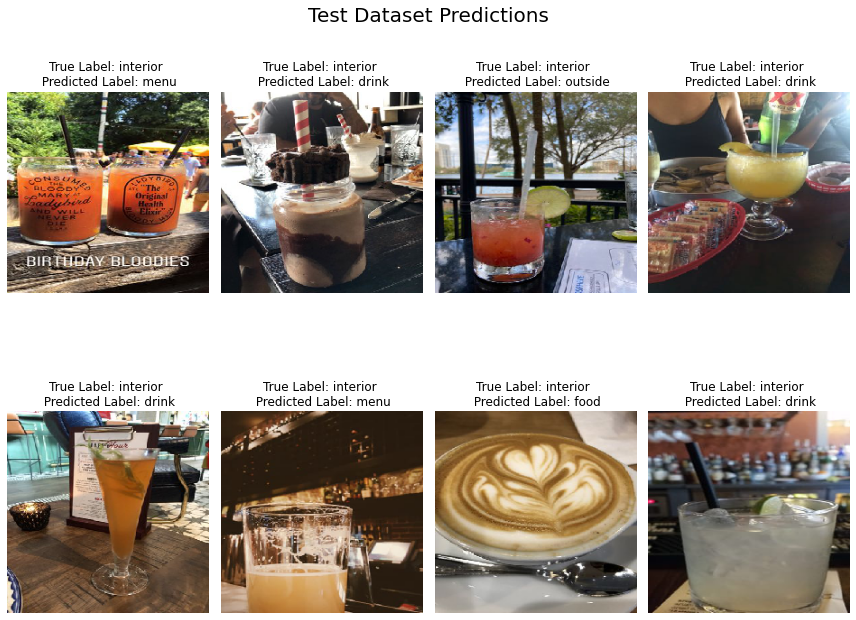

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(preds[idx])]
        ax[i, j].set_title(f"True Label: {label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_ds[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()